In [1]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklego.meta.estimator_transformer import EstimatorTransformer
from scores.probability import crps_cdf
import pandas as pd
from functools import partial

from src.marginal_bootstrap import *

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sklearn.set_config(enable_metadata_routing=True)

In [5]:
plt.style.use("bmh")

In [6]:
SEED = 42
SAMPLE = 200
BOOTSTRAPS_OUTER = 1000
BOOTSTRAPS_INNER = 500

RUNS = 1500

TRUE_MEAN = 0

random_generator = np.random.default_rng(SEED)
sample = random_generator.normal(TRUE_MEAN, 3, SAMPLE)

In [7]:
bootstrap_methods = {
    "bayesian": bootstrap_bayesian,
    "jitter": bootstrap_with_jitter,
    "non_parametric": bootstrap_non_parametric,
    "kde": bootstrap_kde,
}

In [8]:
runs = []
for method_name, method in tqdm(bootstrap_methods.items(), desc="Outer Loop", position=0):
    outer_bootstraps = method(sample, bootstrap_size=BOOTSTRAPS_OUTER, random_generator=random_generator)
    for inner_index, outer_bootstrap in tqdm(enumerate(outer_bootstraps.T), total=BOOTSTRAPS_OUTER, desc=f"Inner Loop - {method_name}"):
        inner_bootstrap = method(outer_bootstrap, bootstrap_size=BOOTSTRAPS_INNER, random_generator=random_generator)
        result = inner_index, method_name, inner_bootstrap.mean(axis=0)
        runs.append(result)

Outer Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Inner Loop - bayesian:   0%|          | 0/500 [00:00<?, ?it/s]

Inner Loop - jitter:   0%|          | 0/500 [00:00<?, ?it/s]

Inner Loop - non_parametric:   0%|          | 0/500 [00:00<?, ?it/s]

Inner Loop - kde:   0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame(runs, columns=["outer_index", "method", "means"]).explode("means")
df

,outer_index,method,means
0,0,bayesian,0.00001
0,0,bayesian,0.000003
0,0,bayesian,-0.000013
0,0,bayesian,-0.000004
0,0,bayesian,-0.0
...,...,...,...
3999,999,kde,-0.567905
3999,999,kde,-0.594066
3999,999,kde,-0.601129
3999,999,kde,-0.48345


In [10]:
summary_df = (
    df.groupby(["method", "outer_index"])
    .agg(
        lower=("means", partial(np.quantile, q=0.025)),
        upper=("means", partial(np.quantile, q=0.975)),
    )
    .assign(
        width=lambda x: x.upper - x.lower,
        midpoint=lambda x: (x.upper + x.lower) / 2,
    )
    .reset_index(drop=False)
)
summary_df

,method,outer_index,lower,upper,width,midpoint
0,bayesian,0,-0.000015,0.000013,0.000028,-8.846538e-07
1,bayesian,1,-0.000015,0.000012,0.000027,-1.434187e-06
2,bayesian,2,-0.000014,0.000009,0.000023,-2.958178e-06
3,bayesian,3,-0.000017,0.000007,0.000024,-4.936894e-06
4,bayesian,4,-0.000010,0.000015,0.000025,2.635145e-06
...,...,...,...,...,...,...
3995,non_parametric,995,-0.832581,-0.159299,0.673281,-4.959400e-01
3996,non_parametric,996,-0.526980,0.257986,0.784965,-1.344969e-01
3997,non_parametric,997,-0.680705,0.053310,0.734015,-3.136979e-01
3998,non_parametric,998,-0.479765,0.208816,0.688581,-1.354745e-01


In [11]:
def coverage_ratio(true_value, lower, upper):
    return np.mean((true_value >= lower) & (true_value <= upper))

In [12]:
def regression_mwi_score(
    y_true,
    lower,
    upper,
    confidence_level: float = 0.95
) -> float:

    y_pis = np.stack([lower, upper]).T[:, :, np.newaxis]
    y_pred_low = np.minimum(y_pis[:, 0, 0], y_pis[:, 1, 0])
    y_pred_up = np.maximum(y_pis[:, 0, 0], y_pis[:, 1, 0])

    width = np.sum(y_pred_up) - np.sum(y_pred_low)  # type: ignore
    error_above = np.sum((y_true - y_pred_up)[y_true > y_pred_up])
    error_below = np.sum((y_pred_low - y_true)[y_true < y_pred_low])
    total_error = error_above + error_below
    mwi = (width + total_error * 2 / (1 - confidence_level)) / len(lower)
    return mwi

In [13]:
def isd_from_kde(samples, grid_size=20):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)
    
    second_deriv = np.gradient(np.gradient(f_vals, dx), dx)
    
    isd = np.sum(second_deriv**2) * dx

    return isd

def entropy(samples, grid_size=20):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)

    f_norm = f_vals / np.sum(f_vals * dx) 
    return -np.sum(f_norm * np.log(f_norm + 1e-12)) * dx

In [14]:
from scipy import stats
from scores.probability import crps_cdf
import xarray

def cprs(true_value, samples, grid_size=20):
    x = np.linspace(min(samples), max(samples), grid_size)
    fcst_cdf = stats.norm.cdf(x, loc=0)
    fcst_array = xarray.DataArray(coords={'temperature': x}, data=fcst_cdf)
    obs_array = xarray.DataArray(true_value)
    return crps_cdf(fcst_array, obs_array, threshold_dim='temperature').total.values.round(3)

In [15]:
runs_df = pd.concat([
    summary_df.groupby("method").sample(frac=1, replace=True, random_state=boot).assign(run=boot)
    for boot in range(RUNS)
])
runs_df

,method,outer_index,lower,upper,width,midpoint,run
684,bayesian,684,-0.000019,0.000006,0.000025,-0.000007,0
559,bayesian,559,-0.000006,0.000018,0.000023,0.000006,0
629,bayesian,629,-0.000018,0.000004,0.000021,-0.000007,0
192,bayesian,192,-0.000019,0.000004,0.000023,-0.000007,0
835,bayesian,835,-0.000010,0.000016,0.000026,0.000003,0
...,...,...,...,...,...,...,...
3676,non_parametric,676,-0.519016,0.168622,0.687638,-0.175197,1499
3126,non_parametric,126,-0.676987,0.001379,0.678366,-0.337804,1499
3825,non_parametric,825,-0.514842,0.228769,0.743611,-0.143037,1499
3561,non_parametric,561,-0.309913,0.378913,0.688826,0.034500,1499


In [16]:
aggregated_metrics = {
    "coverage_ratio": lambda x: coverage_ratio(TRUE_MEAN, x.lower, x.upper),
    "mwi": lambda x: regression_mwi_score(TRUE_MEAN, x.lower, x.upper),
    "width_mean": lambda x: np.mean(x.upper - x.lower),
    "lower_std": lambda x: np.std(x.lower),
    "upper_std": lambda x: np.std(x.upper),
    "entropy_width": lambda x: entropy(x.width),
    "entropy_midpoint": lambda x: entropy(x.midpoint),
    "bias_midpoint": lambda x: x.midpoint - TRUE_MEAN,
}

grouped_runs = runs_df.groupby(["method", "run"])

aggregated_data = {}
for metric_name, metric in aggregated_metrics.items():
    aggregated_data[metric_name] = grouped_runs.apply(metric)

In [17]:
aggregated_df = pd.concat([
    dataframe.to_frame("value").assign(metric=metric_name)
    for metric_name, dataframe in aggregated_data.items()
]).reset_index()

In [18]:
data_metrics = {
    "log(isd)": lambda x: np.log(isd_from_kde(x.means.astype(np.float64))),
    "cprs": lambda x: cprs(TRUE_MEAN, x.means.astype(np.float64)),
    "bias_point": lambda x: x.means - TRUE_MEAN
                        
}

df_grouped = df.groupby(["method", "outer_index"])

data_aggregated_data = {}
for metric_name, metric in data_metrics.items():
    data_aggregated_data[metric_name] = df_grouped.apply(metric)

In [19]:
data_aggregated_df = pd.concat([
    dataframe.to_frame("value").assign(metric=metric_name)
    for metric_name, dataframe in data_aggregated_data.items()
]).reset_index()

In [20]:
study_summary_df = pd.concat([aggregated_df, data_aggregated_df]).drop(["run", "outer_index"], axis=1)
study_summary_df

,method,value,metric
0,bayesian,0.98,coverage_ratio
1,bayesian,0.978,coverage_ratio
2,bayesian,0.97,coverage_ratio
3,bayesian,0.979,coverage_ratio
4,bayesian,0.981,coverage_ratio
...,...,...,...
2007995,non_parametric,-0.327466,bias_point
2007996,non_parametric,-0.213868,bias_point
2007997,non_parametric,-0.0484,bias_point
2007998,non_parametric,-0.22944,bias_point


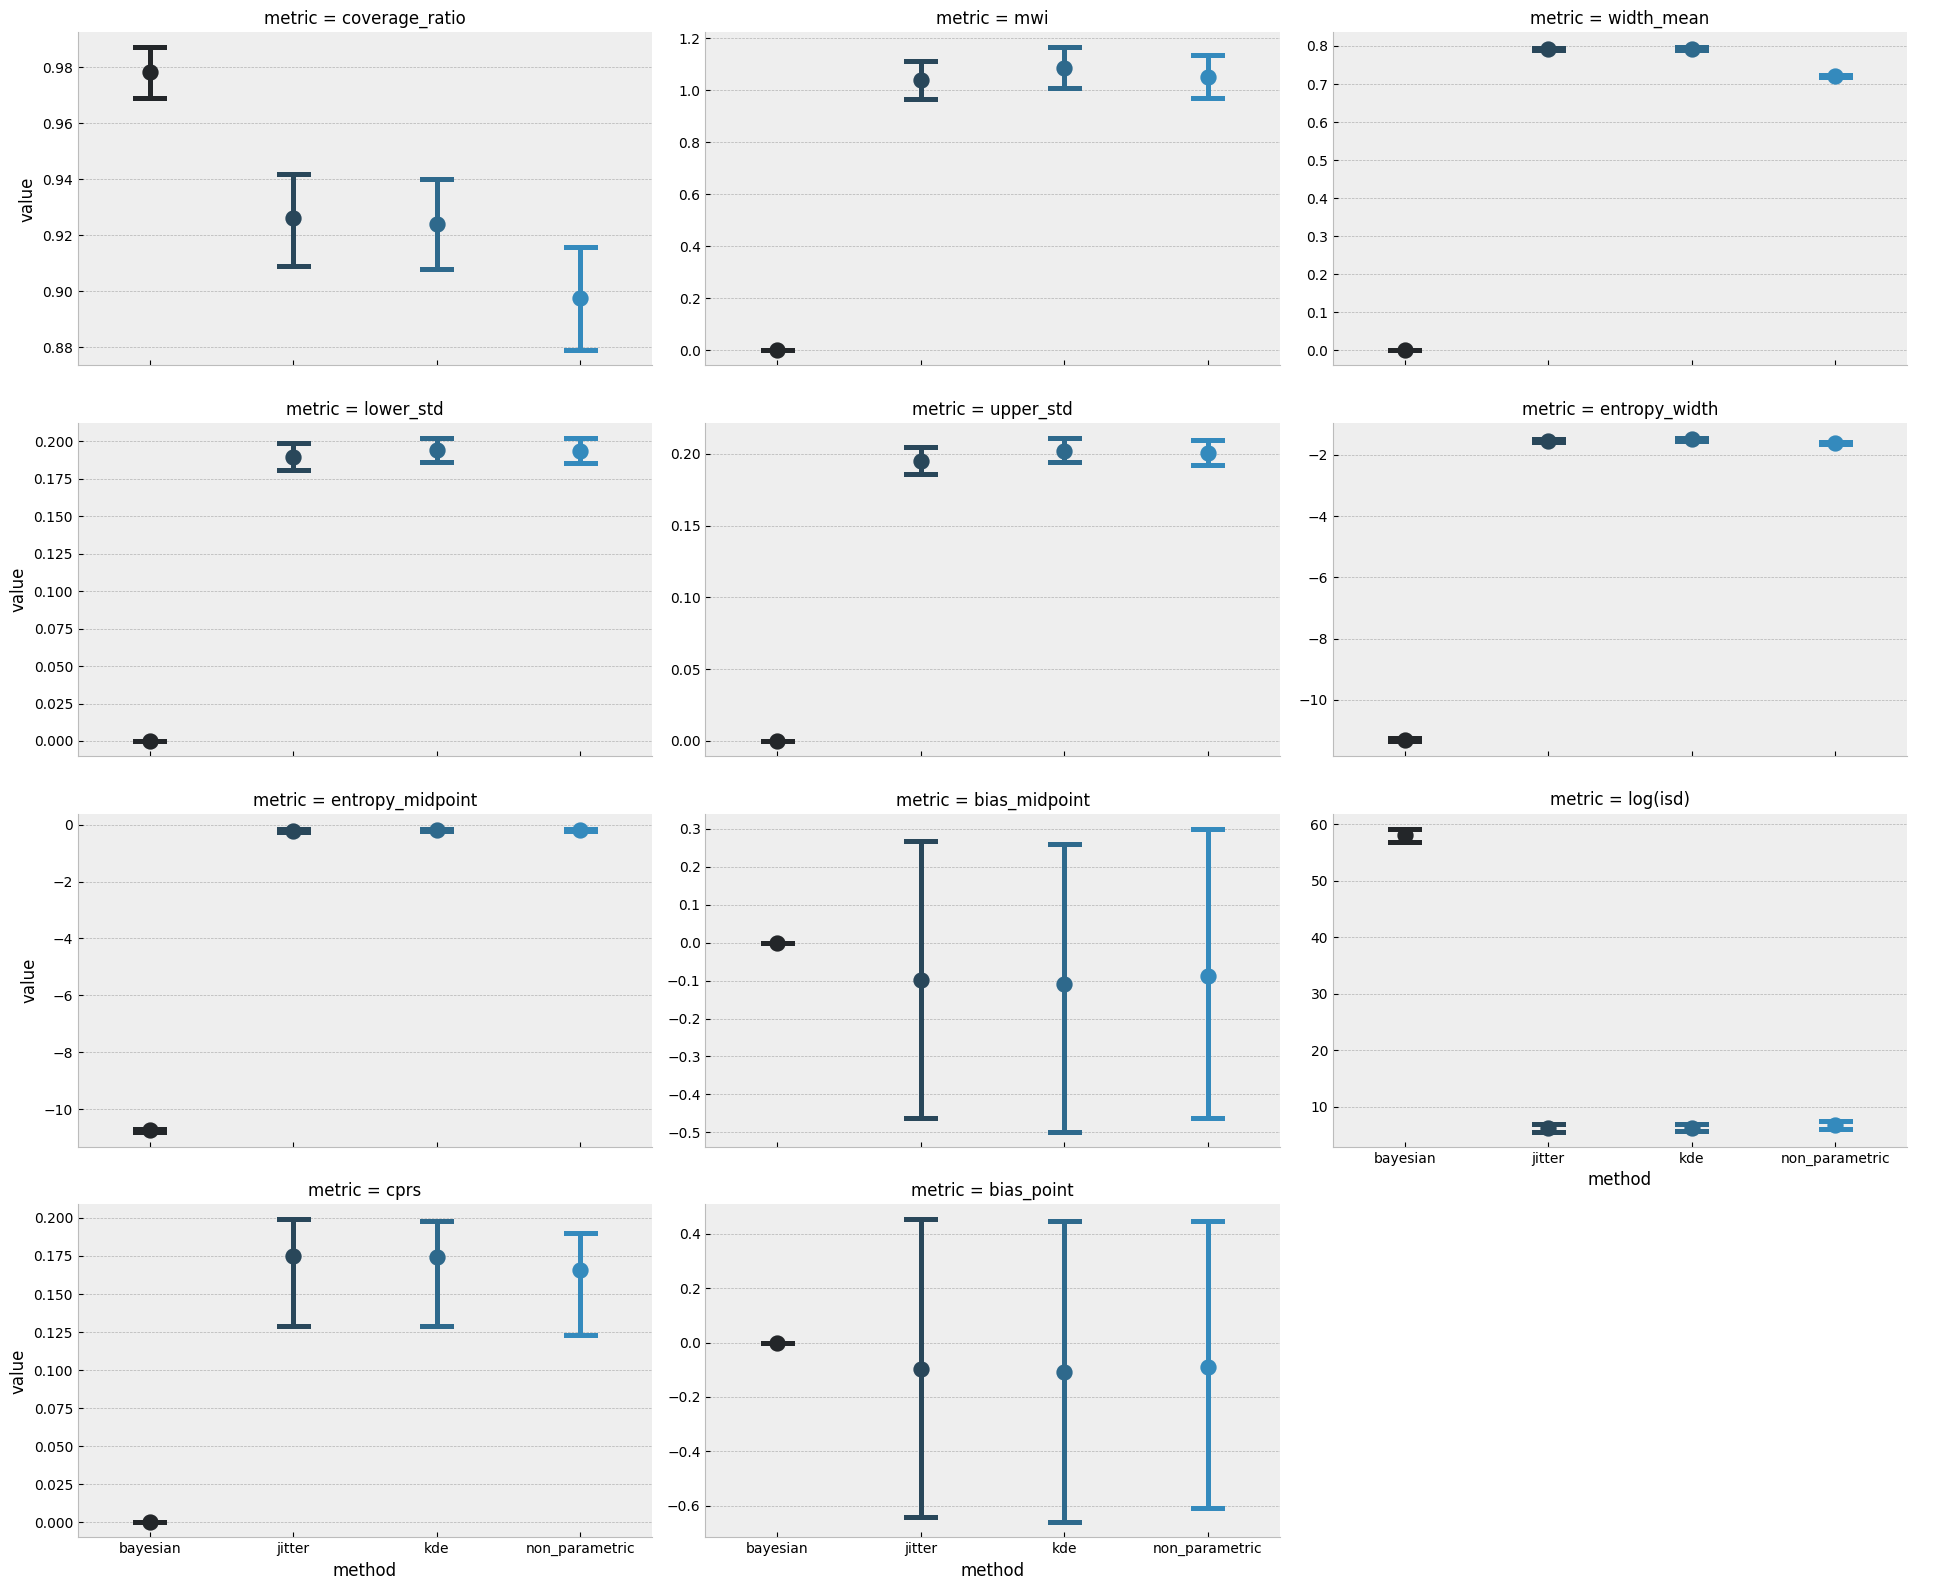

In [21]:
facet = sns.FacetGrid(data=study_summary_df, col="metric", height=4, aspect=1.61, sharey=False, col_wrap=3)
facet.map_dataframe(sns.pointplot, x="method", hue="method", y="value", join=False, errorbar=("pi", 95), capsize=0.2)
facet.add_legend()

In [22]:
df

,outer_index,method,means
0,0,bayesian,0.00001
0,0,bayesian,0.000003
0,0,bayesian,-0.000013
0,0,bayesian,-0.000004
0,0,bayesian,-0.0
...,...,...,...
3999,999,kde,-0.567905
3999,999,kde,-0.594066
3999,999,kde,-0.601129
3999,999,kde,-0.48345


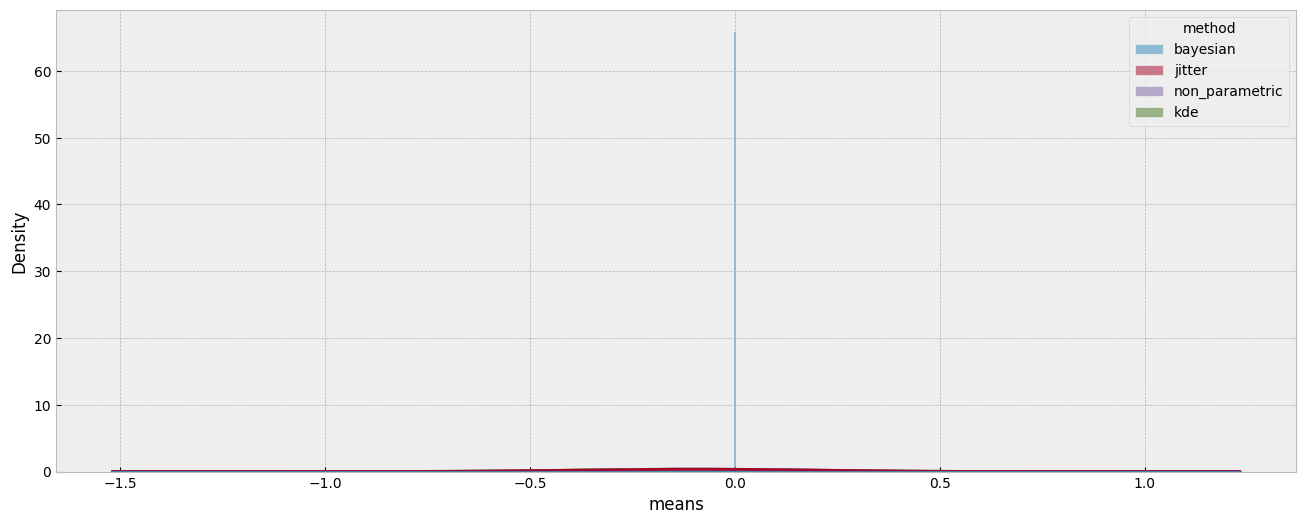

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(data=df, x="means", hue="method", stat="density", ax=ax, kde=True);